In [113]:
# %pip install matplotlib==3.5.3
# %pip install "numpy<2"
# %pip install statsmodels==0.14.0
# %pip install scikit-learn==1.3.2
# %pip install pmdarima==2.0.4
# %pip freeze


In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import auto_arima
from myfunction import adf_test,kpss_test
from sklearn.metrics import mean_squared_error

In [115]:
#% thiết lập thông số cơ bản cho biểu đồ
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 16


In [116]:
#% Nạp dữ liệu phân tích
df = pd.read_csv('/Users/huy/Documents/MÁY HỌC THỐNG KÊ/timeseries analysis/data/ACG.csv', index_col = 'Date', parse_dates = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3201 entries, 2005-02-25 to 2017-11-10
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     3201 non-null   float64
 1   High     3201 non-null   float64
 2   Low      3201 non-null   float64
 3   Close    3201 non-null   float64
 4   Volume   3201 non-null   int64  
 5   OpenInt  3201 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 175.1 KB


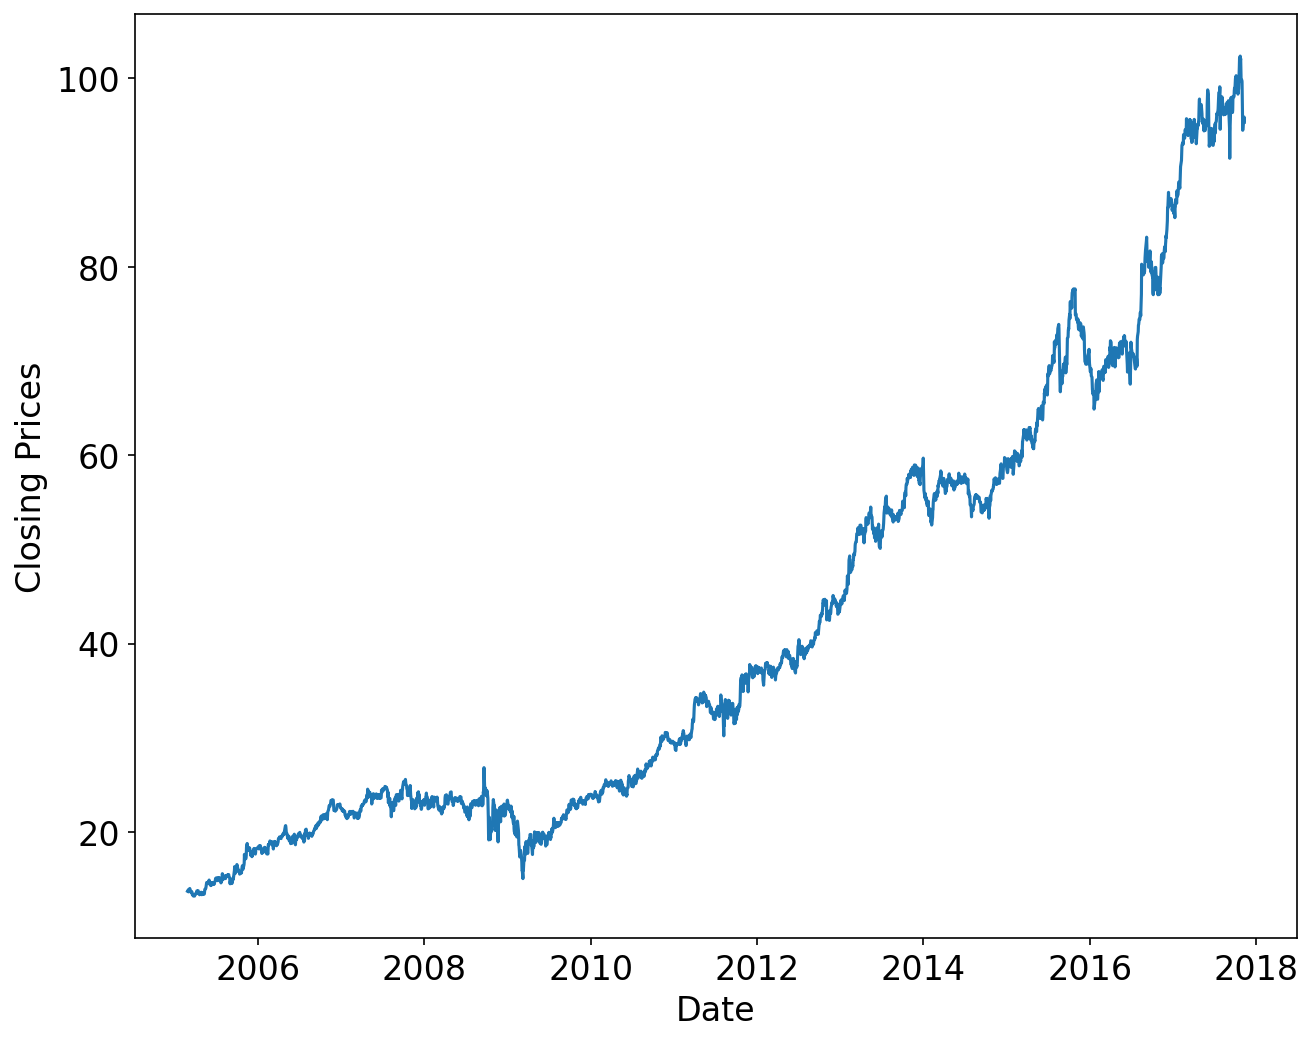

In [117]:
# %% - Vẽ biểu đồ giá đóng cửa cổ phiếu
plt.plot(df['Close'])
plt.xlabel("Date")
plt.ylabel("Closing Prices")
plt.show()

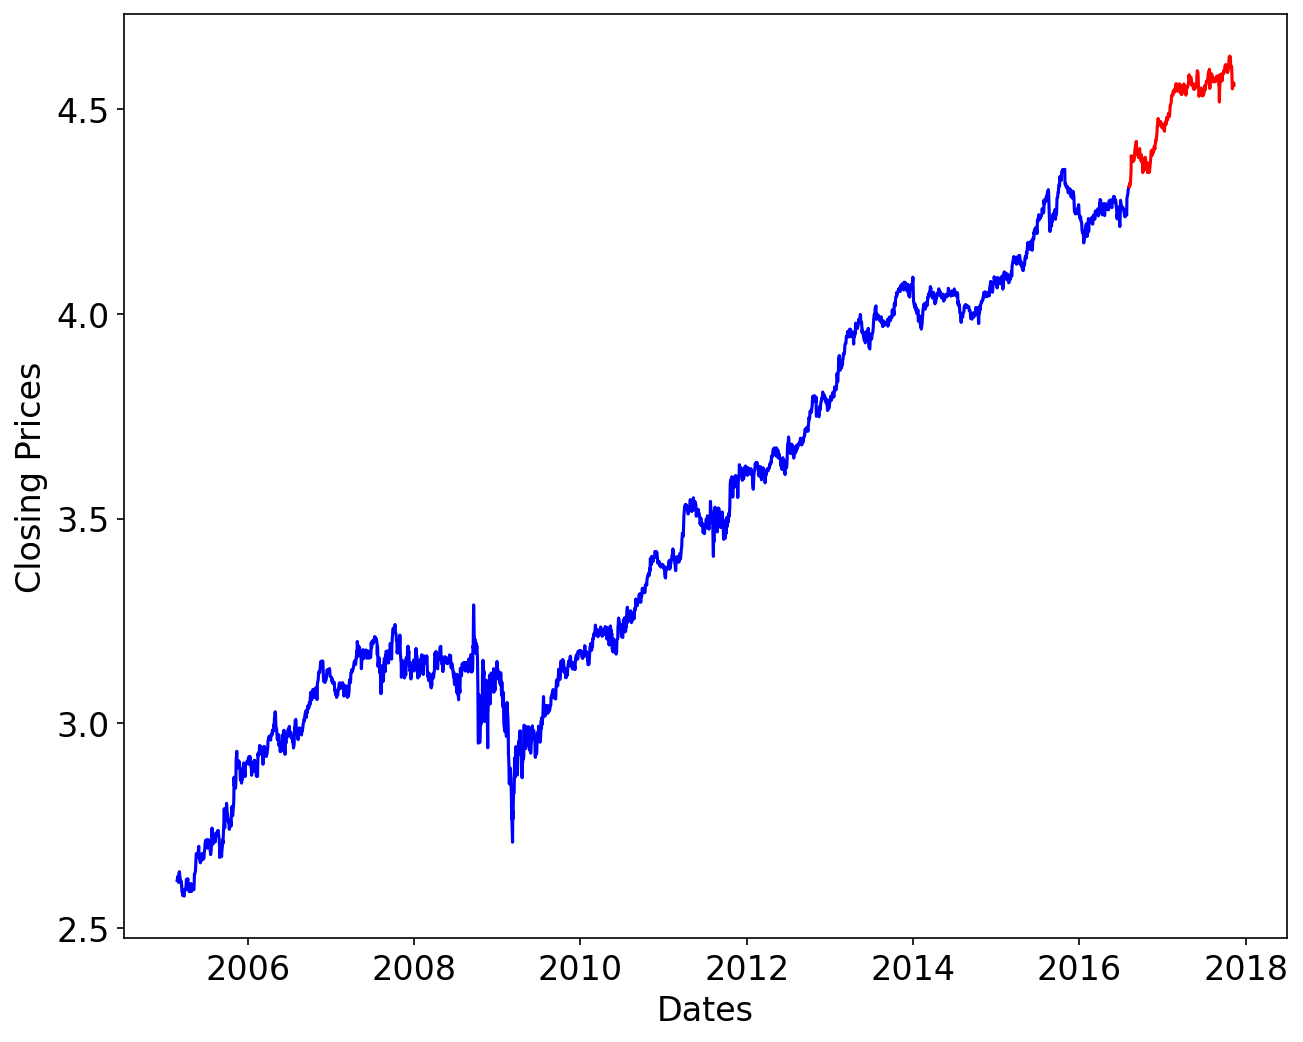

In [118]:
#%% chia dữ liệu huấn luyện (train), kiểm thử (test)
# df_close = df['Close]

df_close = np.log(df['Close'])
train_data, test_data = df_close[:int(len(df_close)*0.9)], df_close[int(len(df_close)*0.9):]

plt.xlabel("Dates")
plt.ylabel("Closing Prices")
plt.plot(train_data, 'blue', label = train_data)
plt.plot(test_data, 'red', label = test_data)
# plt.legend()
plt.show()

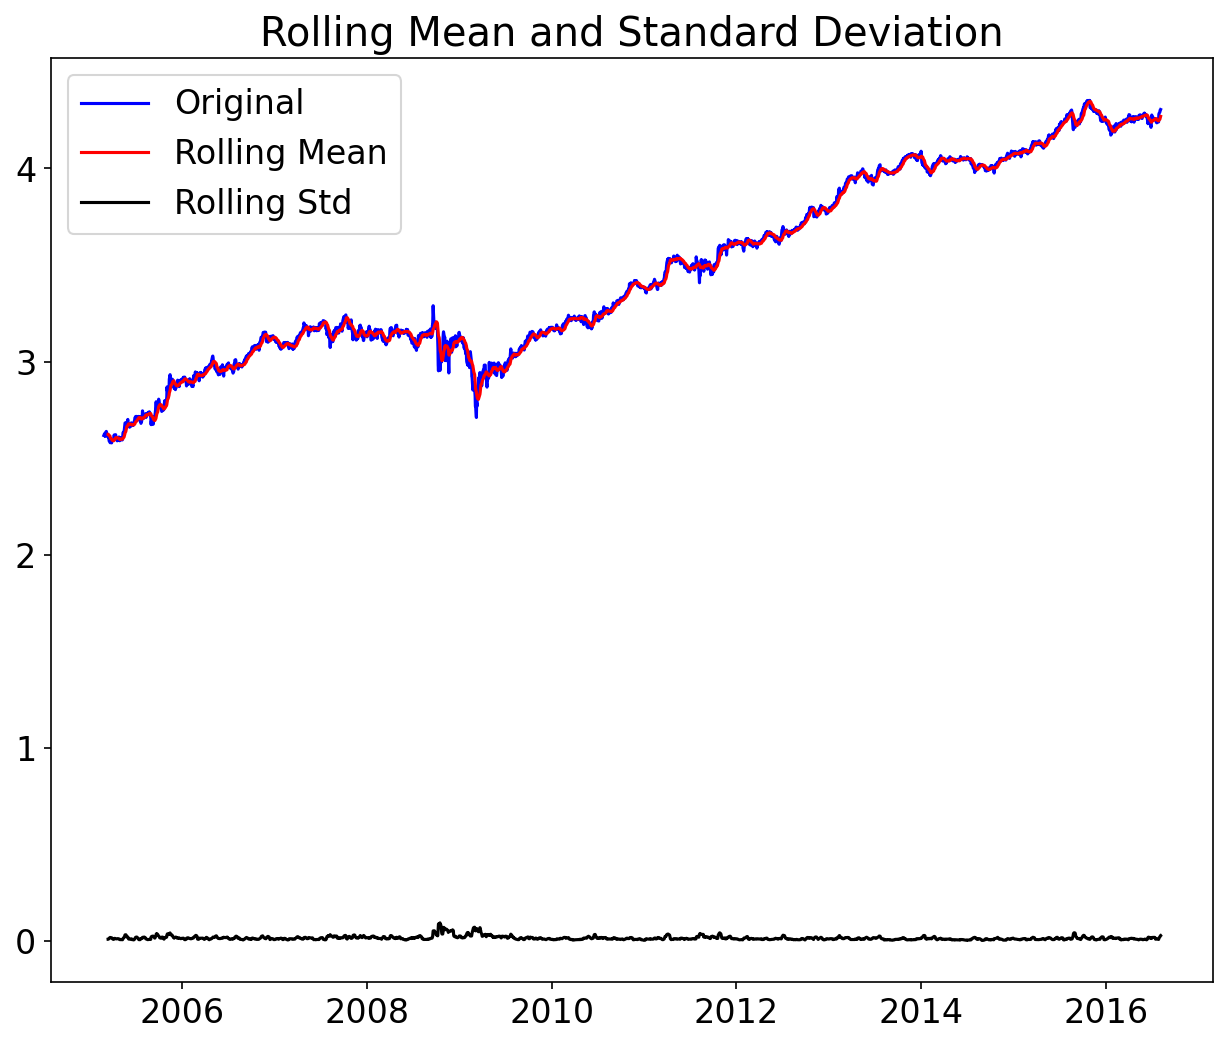

In [119]:
# %% - Phân rã dữ liệu chuỗi thời gian
# vẽ biểu đồ lịch sử so sánh giá đóng cửa cùng với giá trị trung bình và độ lệch chuẩn của 12 kỳ trước đó

rolmean = train_data.rolling(12).mean()
rolstd = train_data.rolling(12).std()
plt.plot(train_data, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend()
plt.title("Rolling Mean and Standard Deviation")
plt.show()

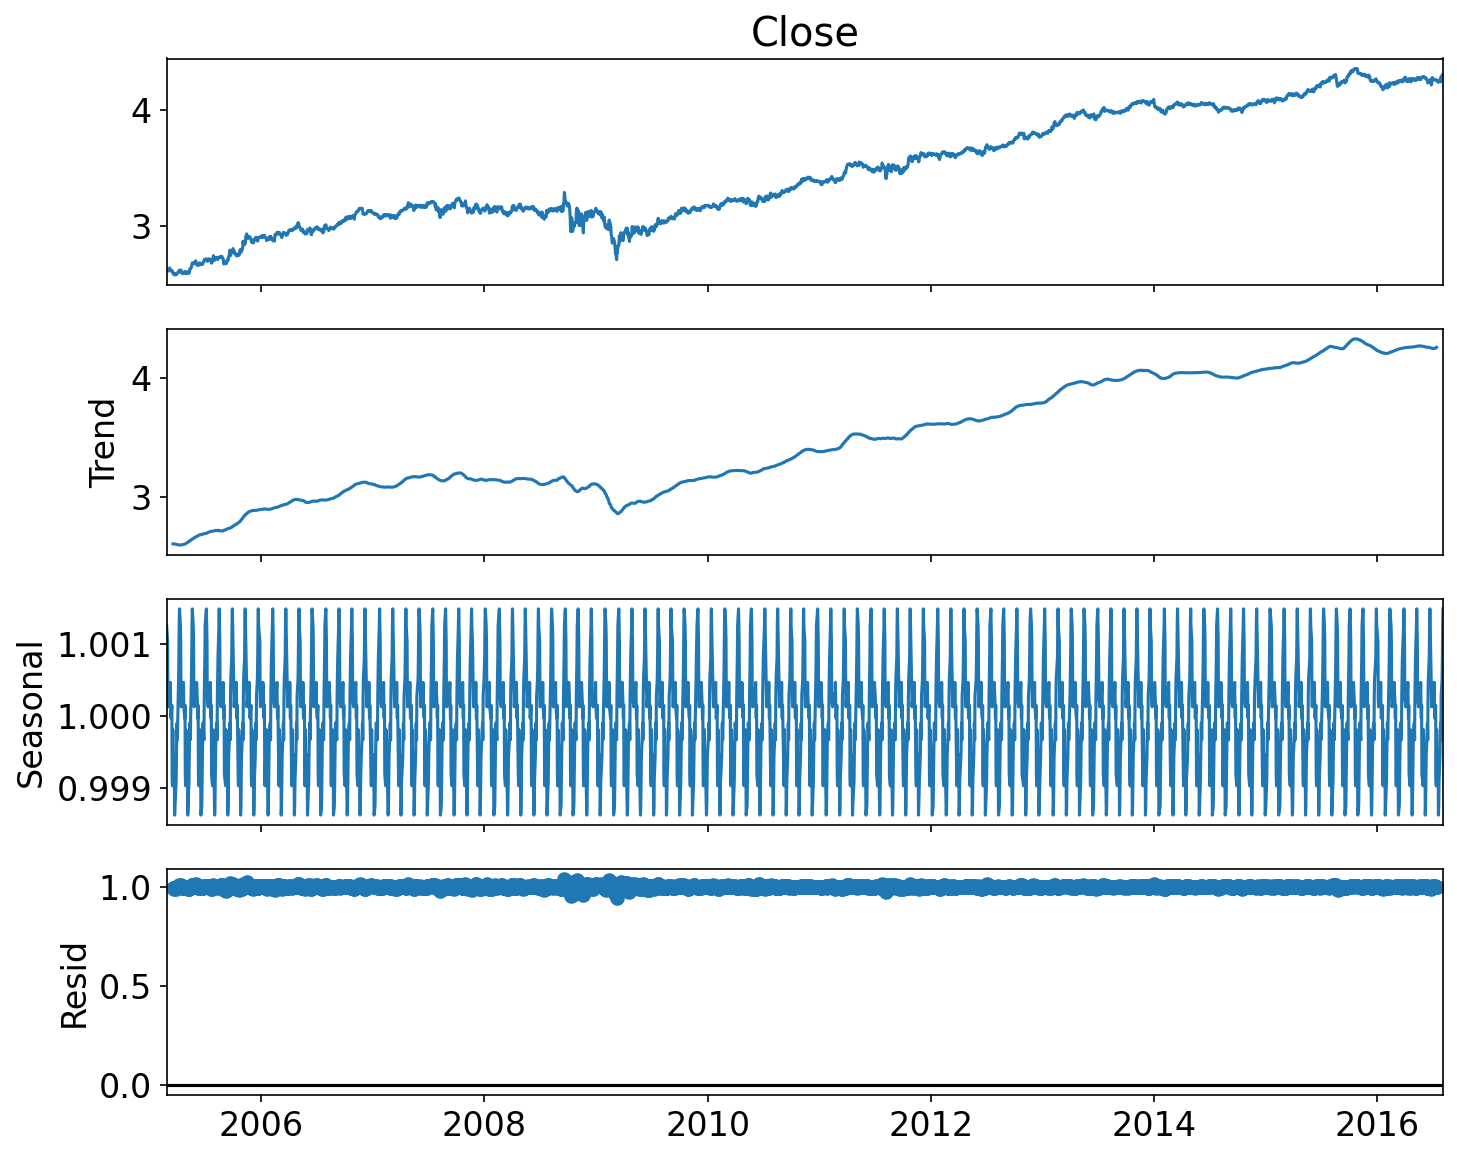

In [120]:
#%% vẽ biểu đồ phân rã chuỗi thời gian (decompose)
# plt.figure(figsize=(18,12), dpi = 200)
decompose_results = seasonal_decompose(train_data, model='multiplicative', period=30)
decompose_results.plot()
plt.show()

In [121]:
# %% kiểm tra tính dừng (stationarity)
print(adf_test(train_data))
print("-----------------"*4)
print(kpss_test(train_data))


Fall to reject the null hypothesis (H0), 
the data is non-stationary
ADF : Test statistic      -0.737048
p value                    0.836918
# of Lags                 15.000000
# of Observations       2864.000000
Critical Value (1%)       -3.432635
Critical Value (5%)       -2.862550
Critical Value (10%)      -2.567307
dtype: float64
--------------------------------------------------------------------
Reject the null hypothesis (H0), 
the data is non-stationary.
KPSS: Test statistic      8.63507
p value                   0.01000
#of Lags                 31.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


/Users/huy/Documents/MÁY HỌC THỐNG KÊ/timeseries analysis/myfunction.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if results[1] <= 0.05:
/Users/huy/Documents/MÁY HỌC THỐNG KÊ/timeseries analysis/myfunction.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  test = kpss(x)
/Users/huy/Documents/MÁY HỌC THỐNG KÊ/timeseries analysis/myfunction.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if results[1] <= 0.05:


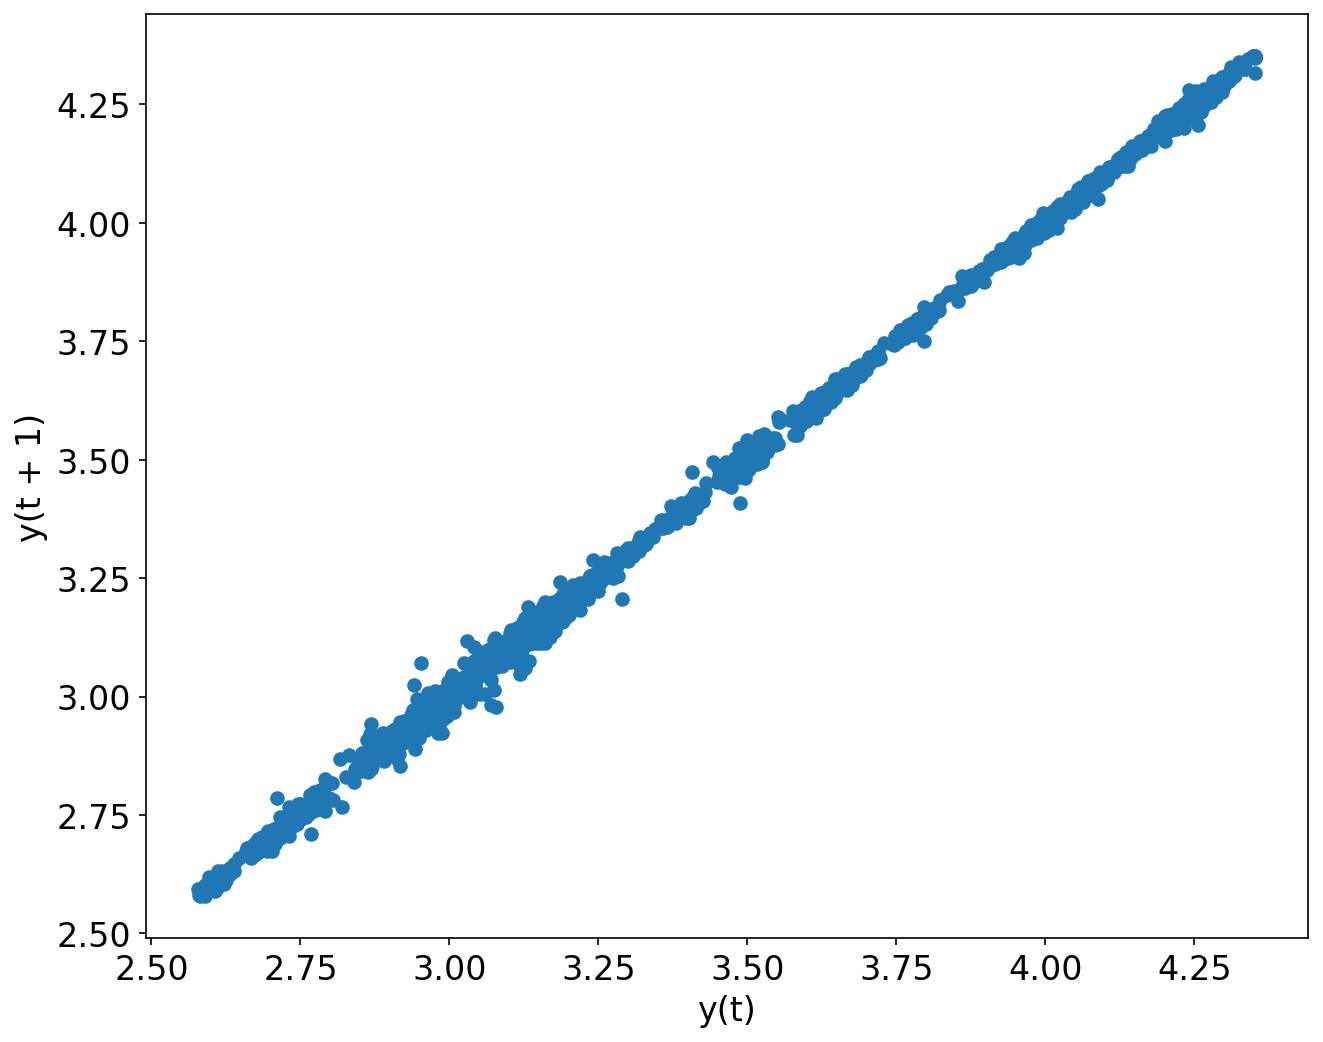

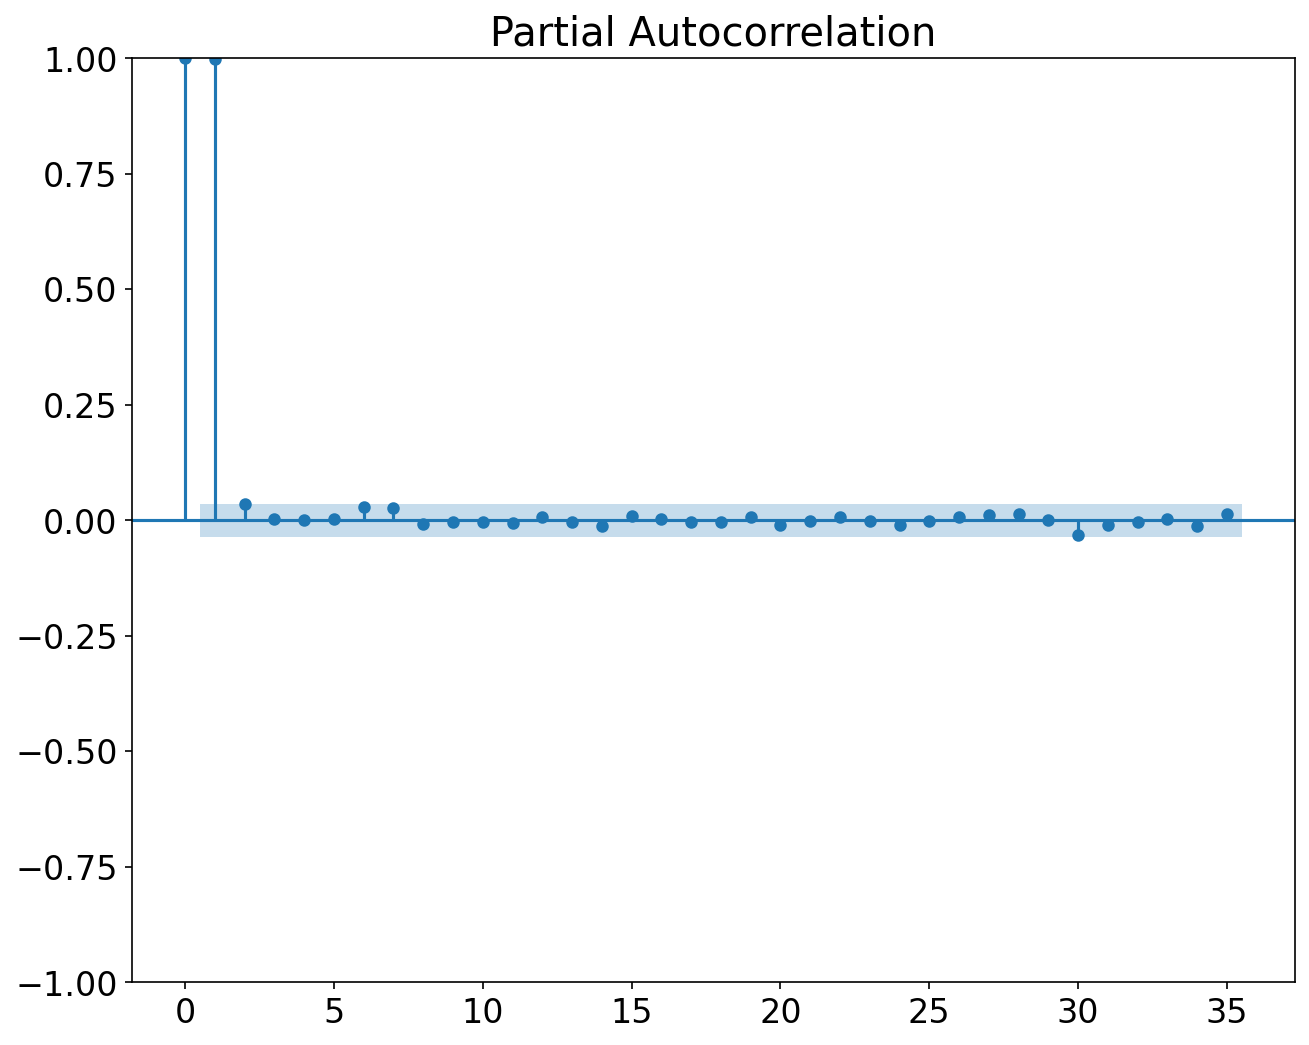

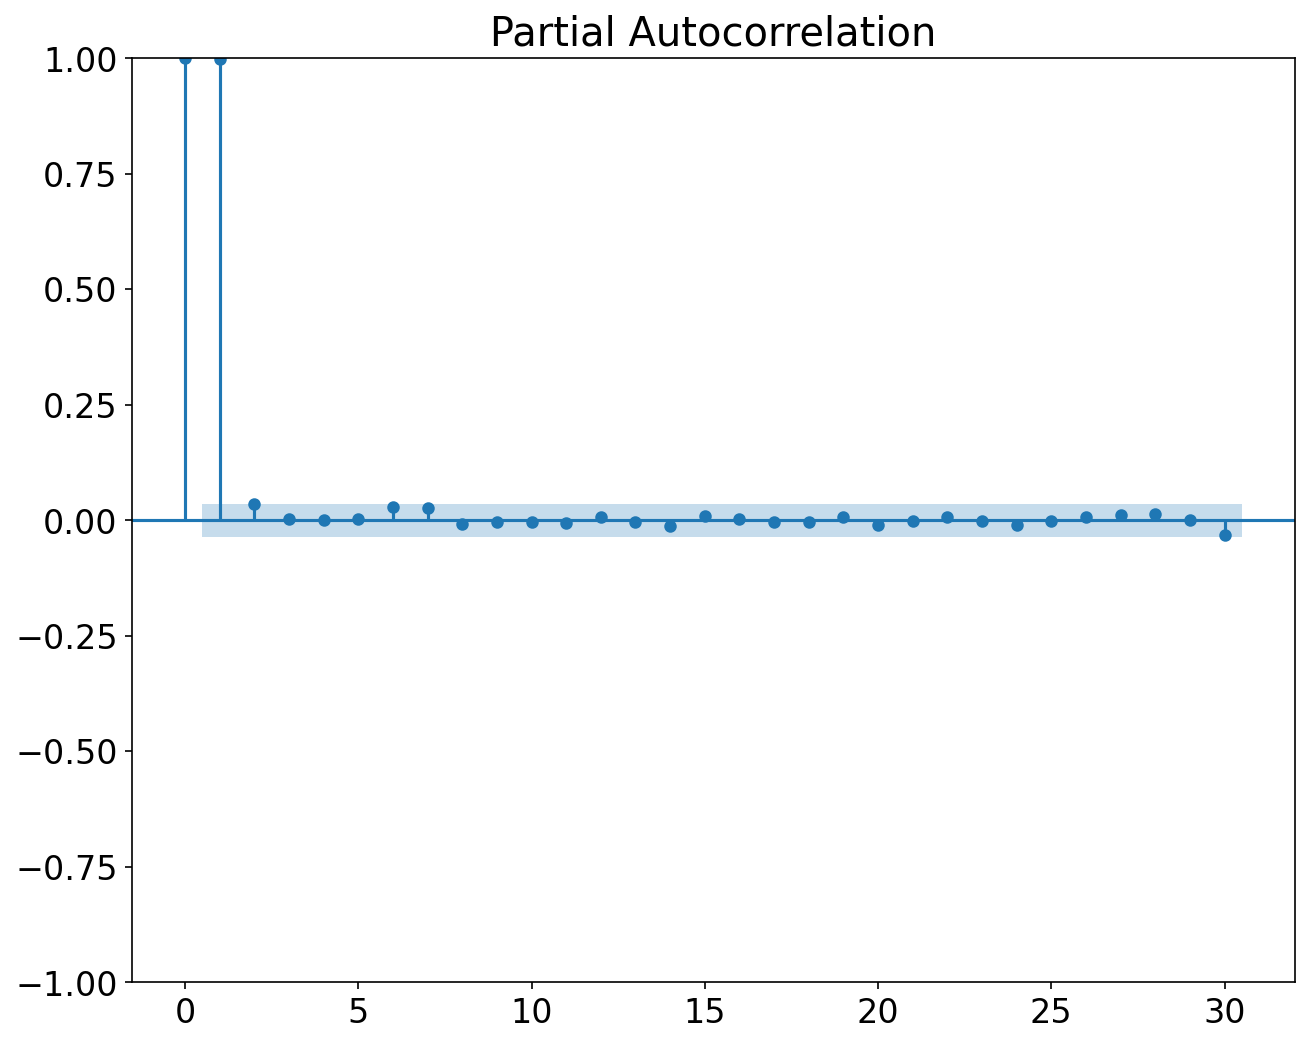

In [122]:
#%%  kiểm định tự tương quan (auto correlation)
pd.plotting.lag_plot(train_data)
#pd.plotting.autocorrelation_plot(df['Close])
plt.show()
plot_pacf(train_data)
plt.show()
plot_pacf(train_data, lags=30)
plt.show()

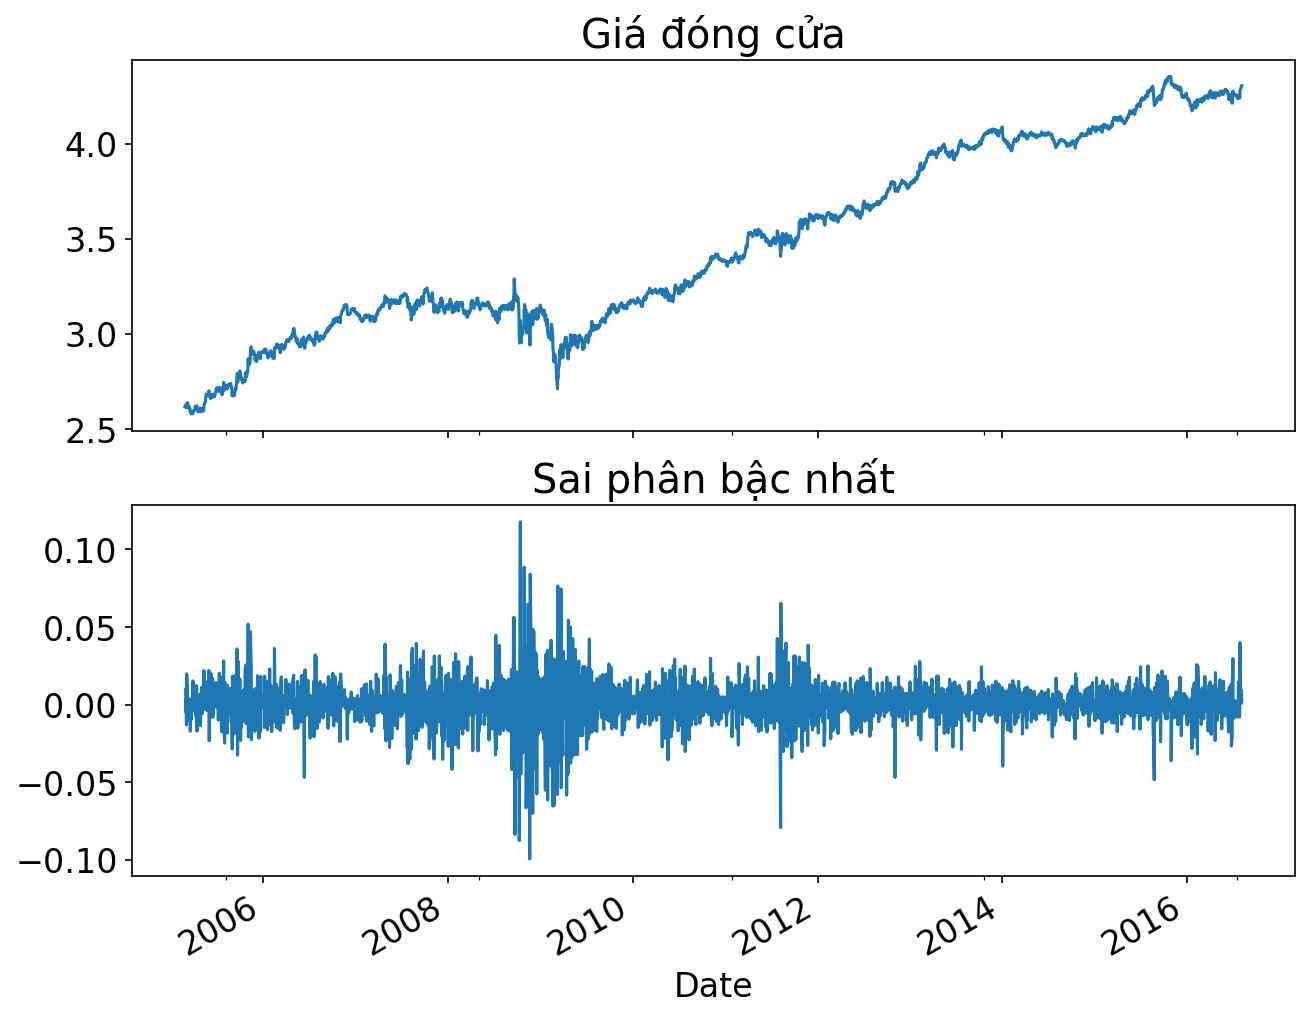

In [123]:
# %%- chuyển đổi chuỗi dừng
# tính sai phân bậc 1 dữ liệu train
diff = train_data.diff(1).dropna()
# biẻu đồ thể hiện dữ liệu ban đầu và sau khi lấy sai phân
fig, ax = plt.subplots(2, sharex="all")
train_data.plot(ax=ax[0], title="Giá đóng cửa")
diff.plot(ax=ax[1], title="Sai phân bậc nhất")
plt.show()

Reject the null hypothesis (H0), 
the data is stationary.
ADF : Test statistic   -1.597475e+01
p value                 6.940782e-29
# of Lags               1.400000e+01
# of Observations       2.864000e+03
Critical Value (1%)    -3.432635e+00
Critical Value (5%)    -2.862550e+00
Critical Value (10%)   -2.567307e+00
dtype: float64
----------------------------------------------------------------
Fail to reject the null hypothesis (H0), 
the data is stationary
KPSS: Test statistic      0.058523
p value                   0.100000
#of Lags                 25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Users/huy/Documents/MÁY HỌC THỐNG KÊ/timeseries analysis/myfunction.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if results[1] <= 0.05:
/Users/huy/Documents/MÁY HỌC THỐNG KÊ/timeseries analysis/myfunction.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  test = kpss(x)
/Users/huy/Documents/MÁY HỌC THỐNG KÊ/timeseries analysis/myfunction.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if results[1] <= 0.05:


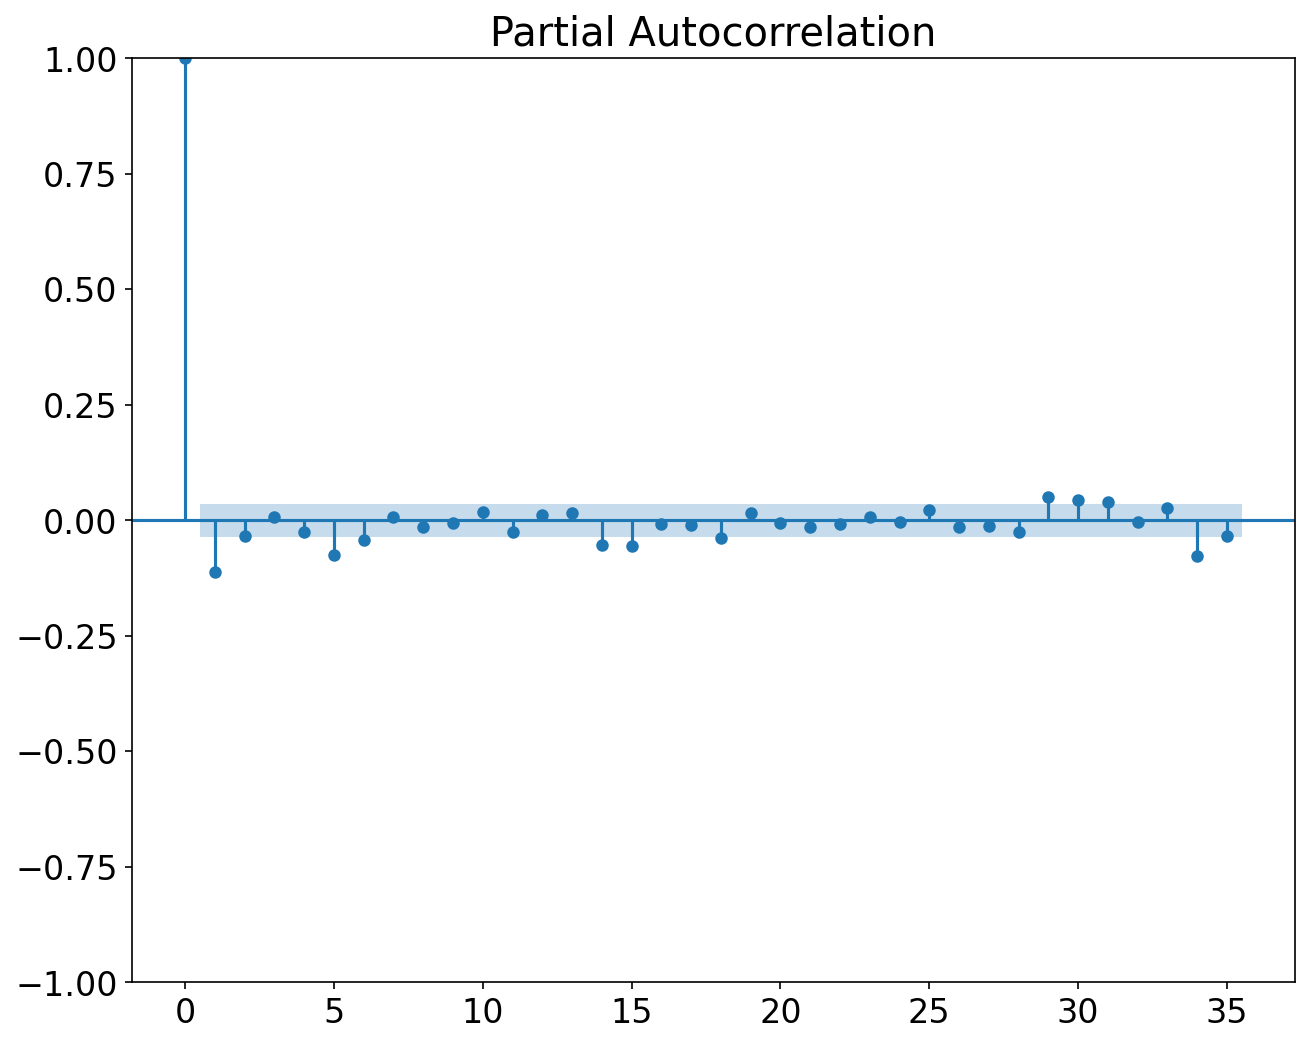

In [124]:
#%%- kiểm tra lại tính dừng của dư liệu sau khi lấy sai phân
print(adf_test(diff))
print("----------------"*4)
print(kpss_test(diff))
plot_pacf(diff)
plt.show()

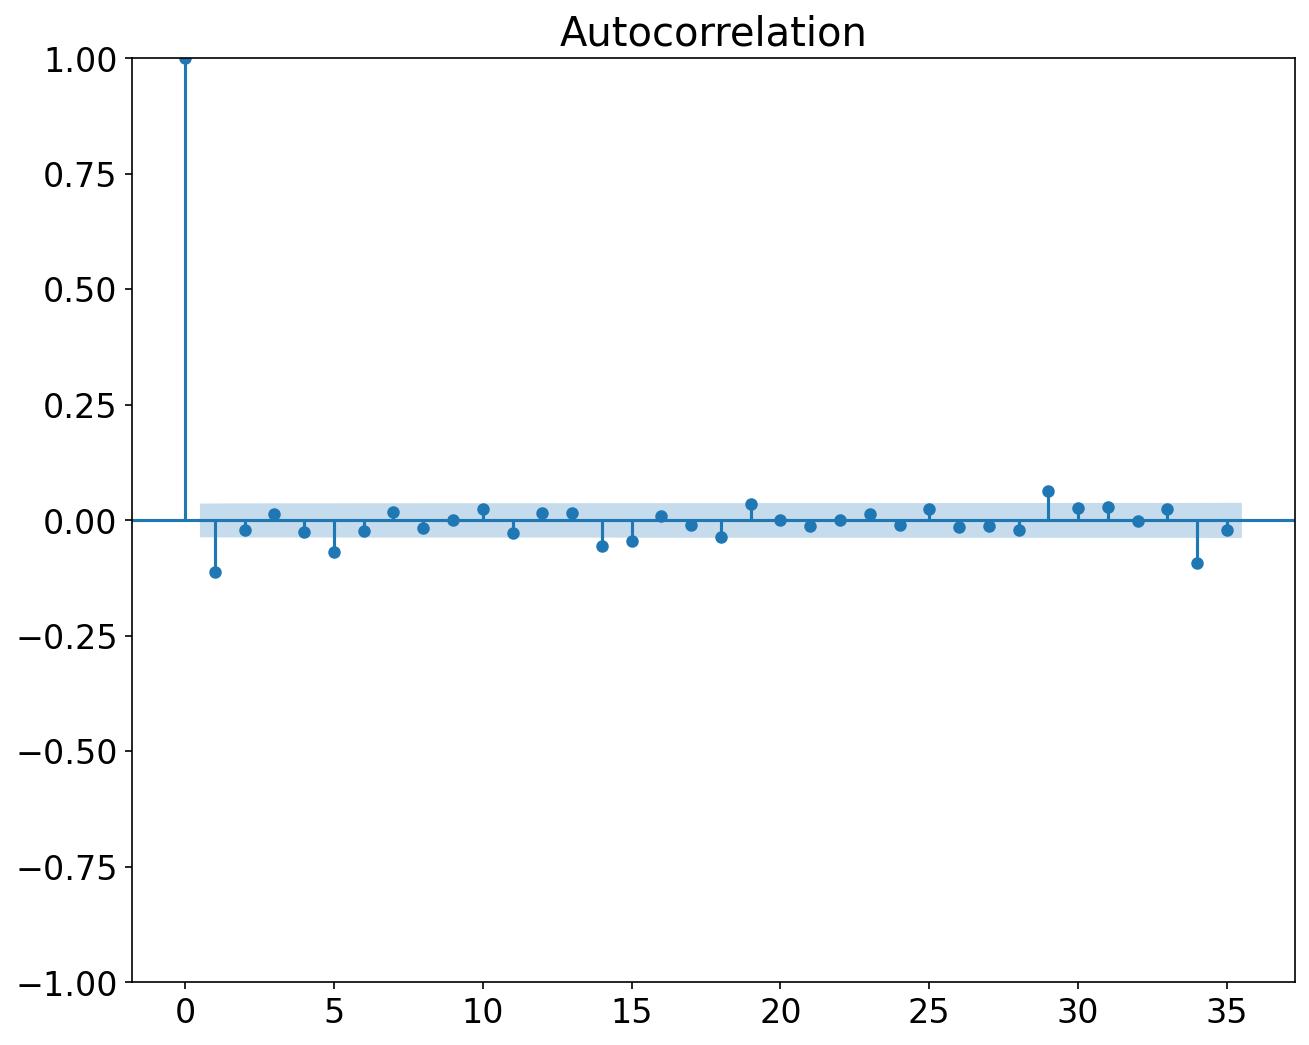

In [125]:
#%%
plot_acf(diff)
plt.show()


In [126]:
#%% - Xác định tham số p,d,q cho mô hình ARIMA

stepwise_fit = auto_arima(train_data, trace=True, suppress_warnings=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16550.100, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16511.067, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16545.696, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16547.662, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16507.830, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16557.262, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16546.796, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16546.834, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-16545.729, Time=0.55 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16544.634, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16545.077, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-16536.028, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-16547.268, Time=0.39 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 4.097 seco

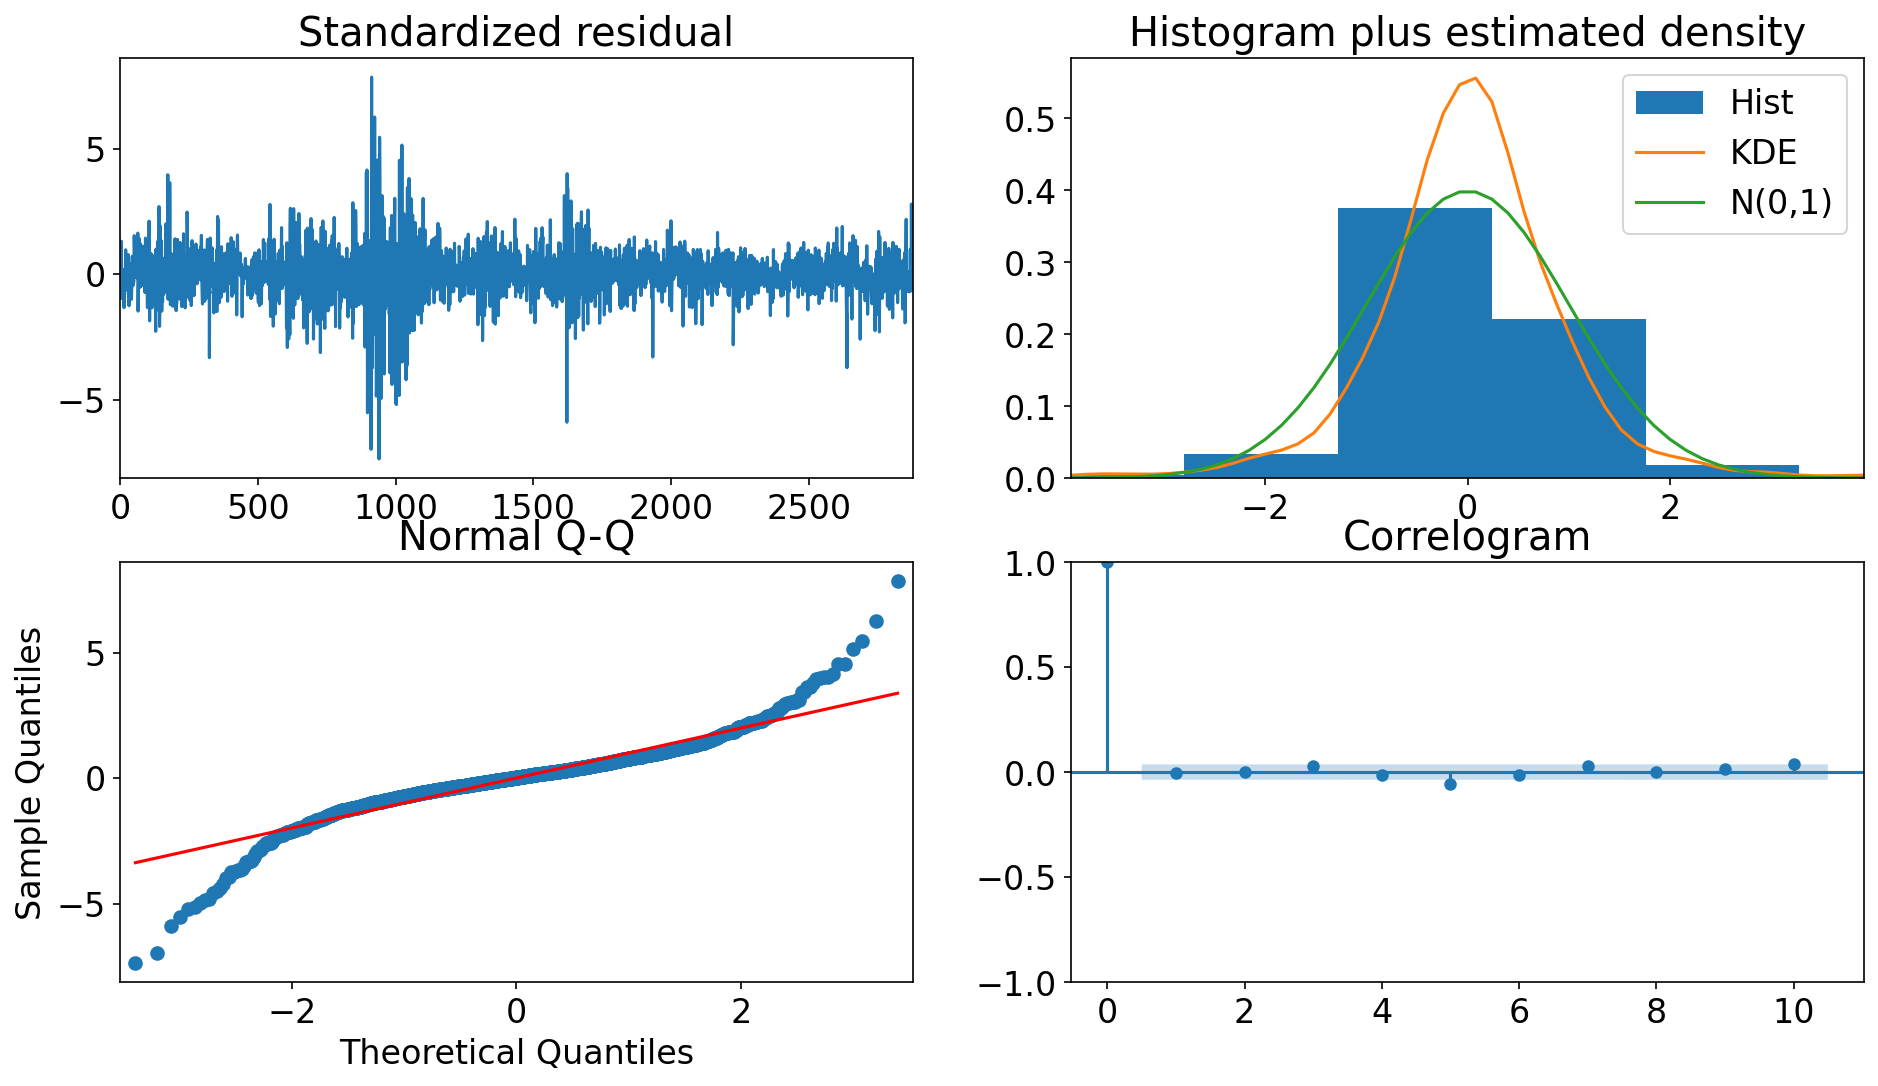

In [140]:

stepwise_fit.plot_diagnostics(figsize=(15, 8))
plt.show()

In [127]:
#%% - Fit mô hình
# model = ARIMA(train_data, order=(1,1,2))
# fitted = model.fit(disp=-1)
#model = ARIMA(train_data, order=(1,1,2))
model = ARIMA(train_data, order=(1,1,2), trend='t')
fitted = model.fit()
print(fitted.summary())

/Users/huy/Documents/MÁY HỌC THỐNG KÊ/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/huy/Documents/MÁY HỌC THỐNG KÊ/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/huy/Documents/MÁY HỌC THỐNG KÊ/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2880
Model:                 ARIMA(1, 1, 2)   Log Likelihood                8260.497
Date:                Mon, 03 Mar 2025   AIC                         -16510.994
Time:                        11:09:02   BIC                         -16481.168
Sample:                             0   HQIC                        -16500.243
                               - 2880                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0006   5.84e-05      9.765      0.000       0.000       0.001
ar.L1          0.9696      0.005    199.635      0.000       0.960       0.979
ma.L1         -1.1023      0.012    -95.717      0.0

In [128]:
#%% dự báo 
# fc, se, conf = fitted.forcast(len(test_data), alpha = 0.05) # 95% conf
# fc_series = pd.Series(fc, index = test_data.index)
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# lower_series = pd.Series(conf[:, 1], index=test_data.index)

fc = fitted.get_forecast(len(test_data))
fc_values = fc.predicted_mean
fc_values.index = test_data.index
conf = fc.conf_int(alpha=0.05) # 95% conf
lower_series = conf['lower Close']
lower_series.index = test_data.index
upper_series = conf['upper Close']
upper_series.index = test_data.index



/Users/huy/Documents/MÁY HỌC THỐNG KÊ/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/huy/Documents/MÁY HỌC THỐNG KÊ/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
#% đánh giá hiệu suất mô hình
mse = mean_squared_error(test_data, fc_values)
print('Test MSEL: %.3f' %mse)
rmse = np.sqrt(mse)
print('Test RMSE: {:.3f}'.format(rmse))

Test MSEL: 0.011
Test RMSE: 0.106


In [130]:
#%% - Calculate RMSE for baseline
baseline_prediction = np.full_like(test_data, train_data.mean())

baseline_rmse = np.sqrt(mean_squared_error(test_data,baseline_prediction))

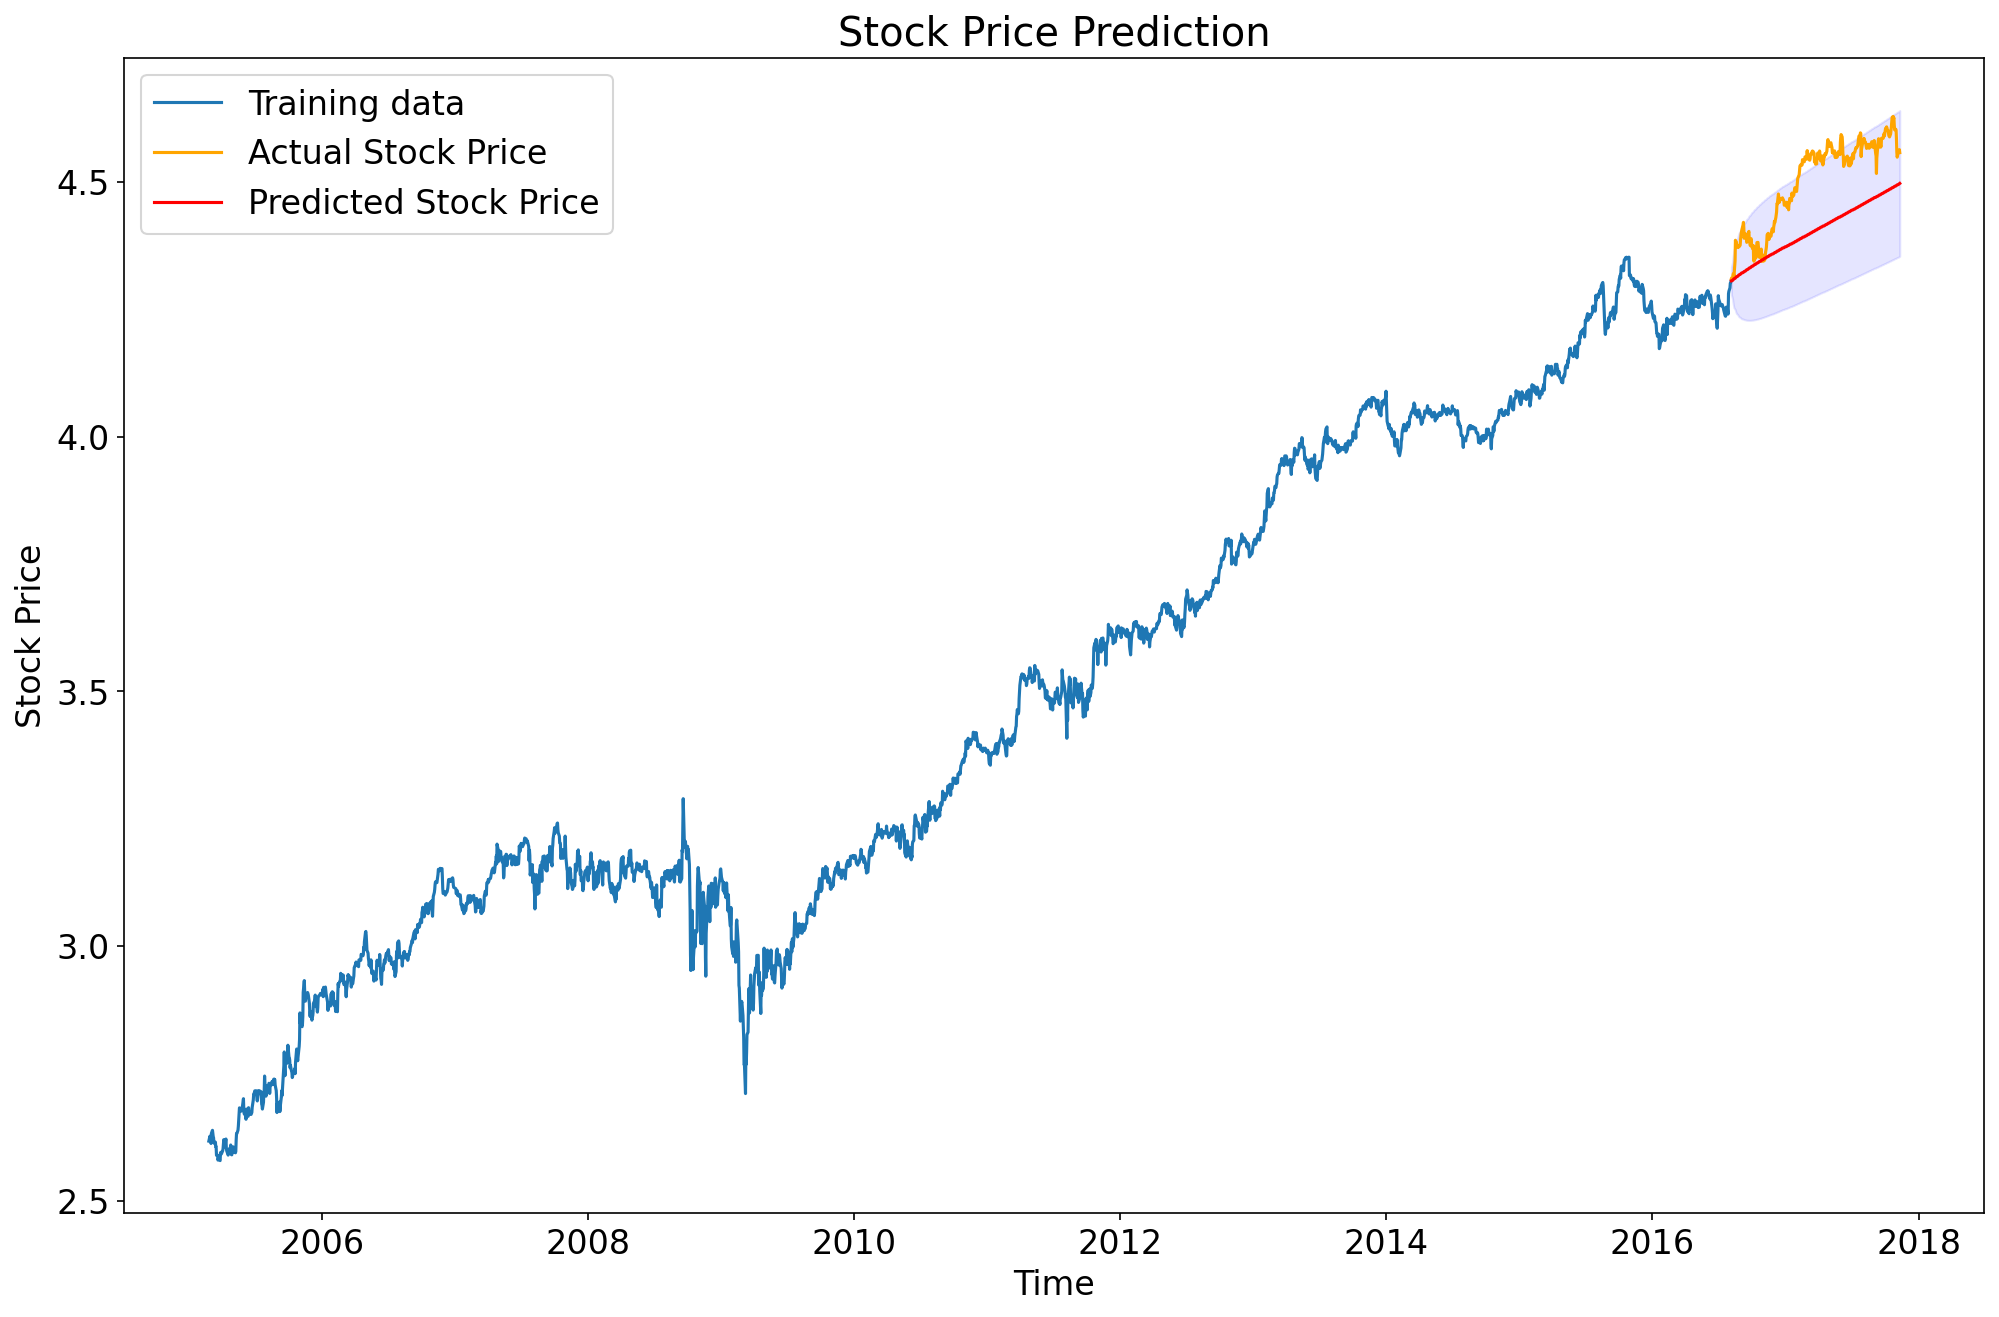

In [131]:
#%% - Plot actual vs predicted values
plt.figure(figsize=(16,10), dpi=150)
plt.plot(train_data,label='Training data')
plt.plot(test_data,color='orange', label='Actual Stock Price')
plt.plot(fc_values, color='red',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='b', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=16)
plt.show()

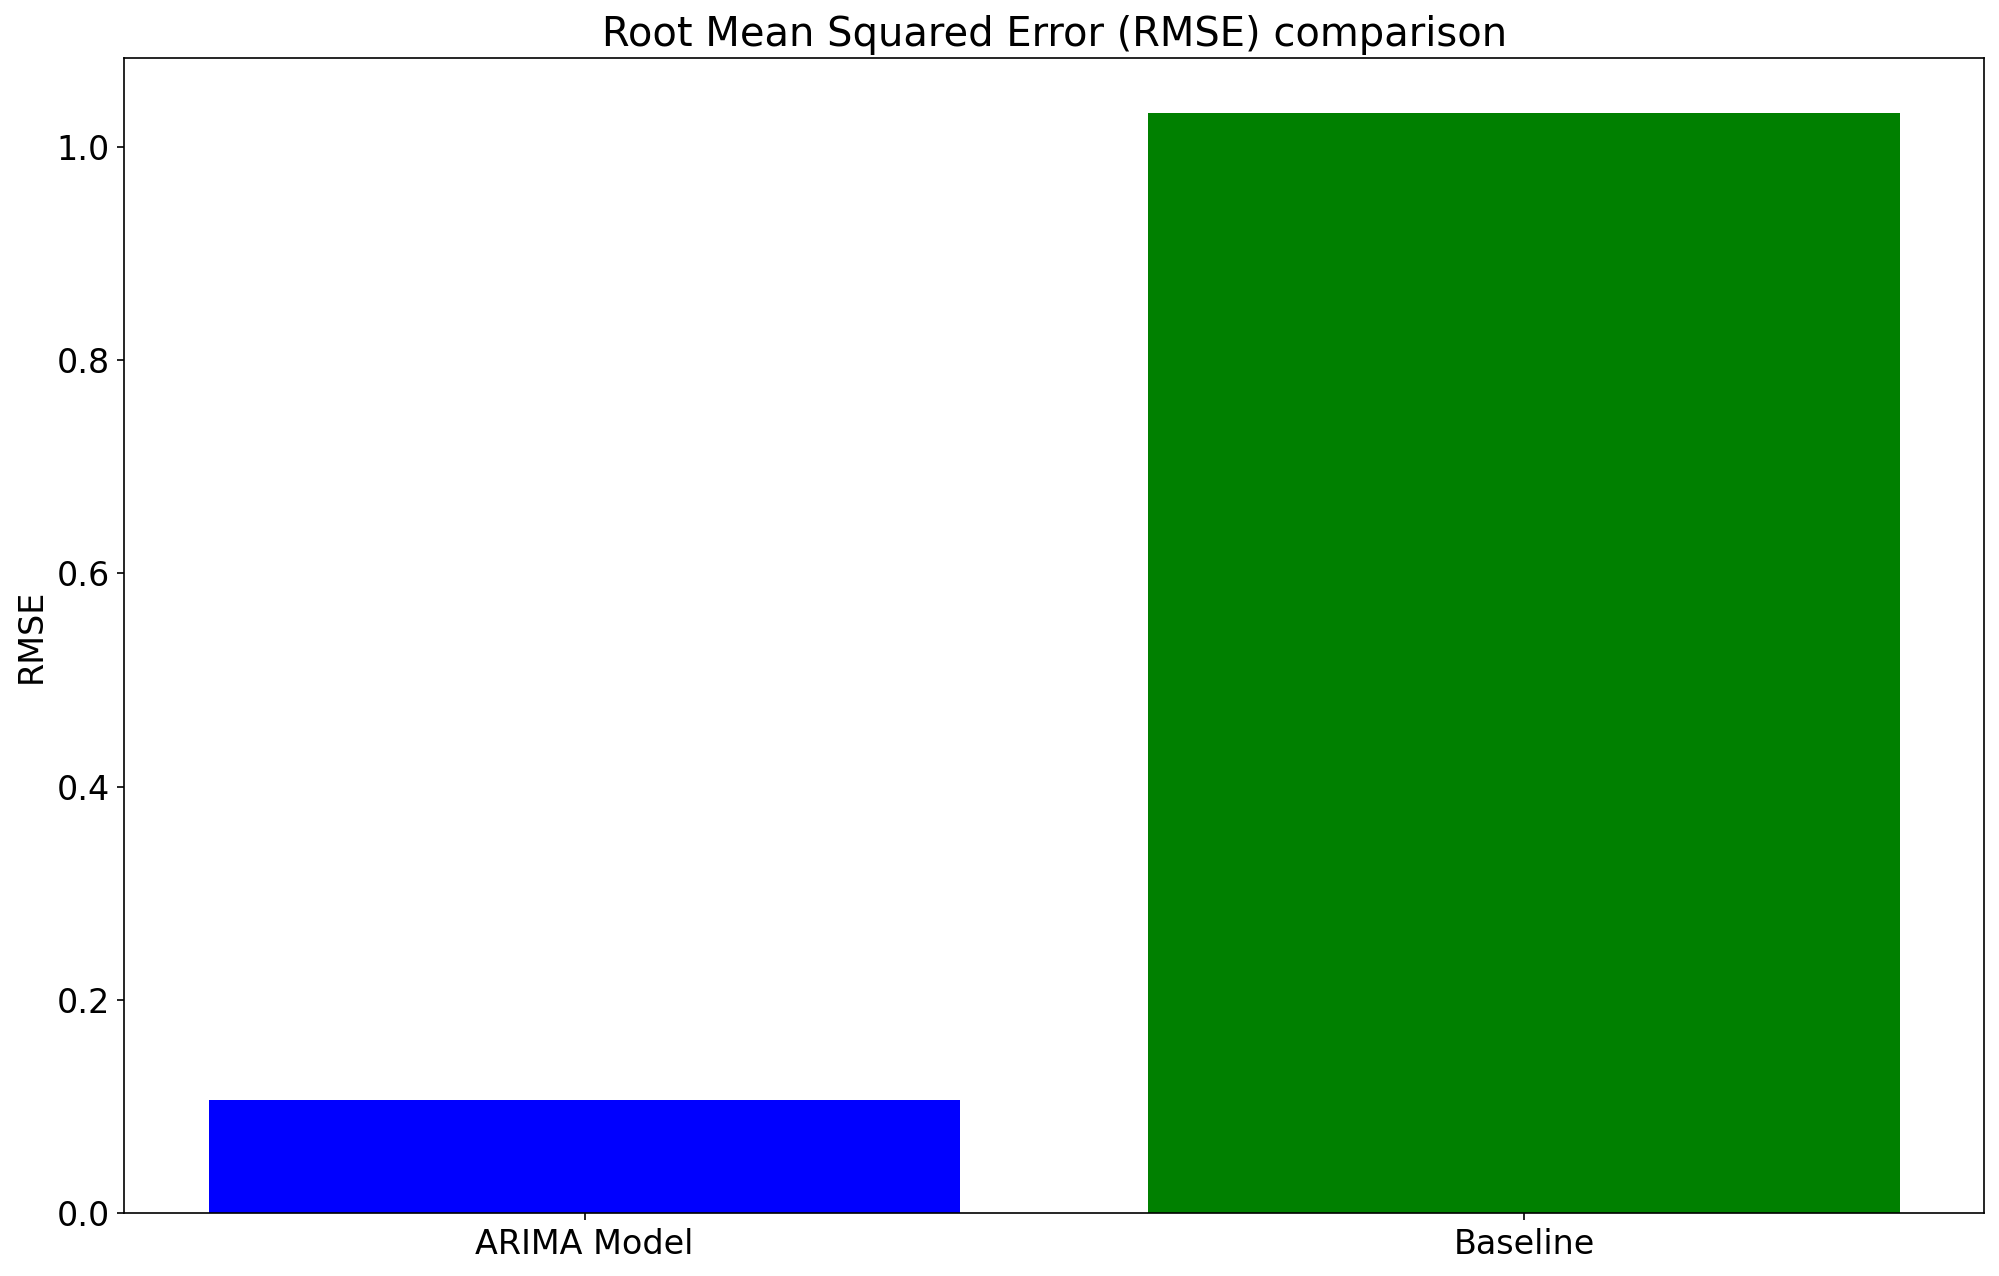

ARIMA Model RMSE: 0.11
Baseline RMSE: 1.03


In [137]:
#%% - Visualize RMSE comparison

import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
plt.bar(['ARIMA Model', 'Baseline'], [rmse, baseline_rmse], color=['blue', 'green'])
plt.title('Root Mean Squared Error (RMSE) comparison')
plt.ylabel('RMSE')
plt.show()

print('ARIMA Model RMSE: {:.2f}'.format(rmse))
print('Baseline RMSE: {:.2f}'.format(baseline_rmse))